In [6]:
import json, os
import pandas as pd

path = r"C:\Users\dinak\Untitled Folder 2\Coding-Doc-Agent\drift_dataset_final_87.jsonl"

def load_json_or_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        first = f.read(1)
        f.seek(0)
        if first == "[":
            return json.load(f)  
        else:
            rows = []
            for line in f:
                line = line.strip()
                if line:
                    rows.append(json.loads(line))
            return rows

data = load_json_or_jsonl(path)
df = pd.DataFrame(data)

print("Records:", len(df))
print("Columns:", df.columns.tolist())
df.head(3)

Records: 87
Columns: ['repository', 'commit_sha', 'commit_message', 'commit_date', 'author', 'file', 'patch', 'before_segments', 'after_segments']


,repository,commit_sha,commit_message,commit_date,author,file,patch,before_segments,after_segments
0,psf/requests,5f338446f9eabd956e7e132668f330d9de4fc368,Update docstring for Session.verify to include...,2026-02-13T02:52:04+00:00,m0d3v,src/requests/sessions.py,"@@ -422,6 +422,8 @@ def __init__(self):\n ...","[{'filename': 'src/requests/sessions.py', 'sta...","[{'filename': 'src/requests/sessions.py', 'sta..."
1,psf/requests,a7e1c745dc23c18e836febd672416ed0c5d8d8ae,Update docs/conf.py\n\nCo-authored-by: Nate Pr...,2025-05-31T16:59:51+00:00,Ian Stapleton Cordasco,docs/conf.py,"@@ -58,7 +58,7 @@\n \n # General information a...",[],[]
2,psf/requests,0b4d494192de489701d3a2e32acef8fb5d3f042e,Merge pull request #6581 from EFord36/typo-fix...,2023-11-22T15:10:47+00:00,Ian Stapleton Cordasco,src/requests/utils.py,"@@ -859,7 +859,7 @@ def select_proxy(url, prox...","[{'filename': 'src/requests/utils.py', 'start_...","[{'filename': 'src/requests/utils.py', 'start_..."


In [7]:
import re
from datetime import datetime

def file_type(fp: str):
    fp = (fp or "").lower()
    name = fp.split("/")[-1]
    if "readme" in name:
        return "readme"
    if name.endswith(".md"):
        return "markdown"
    if "docs/" in fp or "/doc/" in fp:
        return "docs_folder"
    if name.endswith(".rst"):
        return "rst"
    if name.endswith(".py"):
        return "python"
    return "other"

KEYWORDS = ["docs","doc","readme","deprecated","deprecate","breaking","api","fix","update","rename","remove"]

df["commit_date"] = pd.to_datetime(df.get("commit_date", None), errors="coerce")
df["file_type"] = df["file"].apply(file_type)

msg = df["commit_message"].fillna("").str.lower()
for kw in KEYWORDS:
    df[f"kw_{kw}"] = msg.str.contains(rf"\b{re.escape(kw)}\b", regex=True)

df["diff_len"] = df["patch"].fillna("").apply(lambda s: len(s.splitlines()))

df["label_major_change"] = (
    df["kw_deprecated"] | df["kw_breaking"] | df["kw_rename"] | df["kw_remove"]
).astype(int)

df[["repository","file","file_type","diff_len","label_major_change"]].head(5)

,repository,file,file_type,diff_len,label_major_change
0,psf/requests,src/requests/sessions.py,python,9,0
1,psf/requests,docs/conf.py,docs_folder,9,0
2,psf/requests,src/requests/utils.py,python,9,0
3,psf/requests,src/requests/utils.py,python,9,0
4,pallets/flask,src/flask/app.py,python,9,0


In [8]:
from collections import Counter

print("Total records:", len(df))

print("\nTop repos:")
display(df["repository"].value_counts().head(10).to_frame("events"))

print("\nTop file types:")
display(df["file_type"].value_counts().to_frame("events"))

print("\nTop filenames:")
display(df["file"].fillna("").apply(lambda x: x.split("/")[-1]).value_counts().head(10).to_frame("events"))

print("\nKeyword hits (commit message):")
kw_cols = [c for c in df.columns if c.startswith("kw_")]
kw_counts = df[kw_cols].sum().sort_values(ascending=False)
display(kw_counts.to_frame("count"))

Total records: 87

Top repos:


,events
encode/starlette,27
scipy/scipy,21
pydantic/pydantic,11
matplotlib/matplotlib,7
numpy/numpy,7
pallets/flask,5
psf/requests,4
scikit-learn/scikit-learn,4
pandas-dev/pandas,1



Top file types:


,events
python,84
other,2
docs_folder,1



Top filenames:


,events
__init__.py,12
sessions.py,2
config.py,2
_axes.py,2
responses.py,2
_stats_py.py,2
_ltisys.py,2
websockets.py,2
app.py,2
utils.py,2



Keyword hits (commit message):


,count
kw_update,58
kw_fix,37
kw_docs,34
kw_doc,32
kw_remove,13
kw_rename,8
kw_api,4
kw_deprecated,2
kw_deprecate,2
kw_readme,0


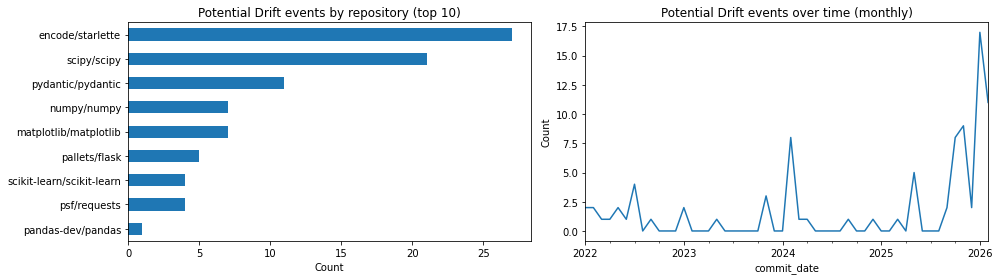

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

top_repo = df["repository"].value_counts().head(10).sort_values()
has_dates = df["commit_date"].notna().any()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

top_repo.plot(kind="barh", ax=axes[0])
axes[0].set_title("Potential Drift events by repository (top 10)")
axes[0].set_xlabel("Count")

if has_dates:
    dft = df.dropna(subset=["commit_date"]).copy()
    dft["commit_date"] = pd.to_datetime(dft["commit_date"], errors="coerce")
    dft = dft.dropna(subset=["commit_date"]).set_index("commit_date")

    by_month = dft.resample("MS").size()  
    by_month.plot(ax=axes[1])
    axes[1].set_title("Potential Drift events over time (monthly)")
    axes[1].set_xlabel("commit_date")
    axes[1].set_ylabel("Count")
else:
    axes[1].axis("off")
    axes[1].text(0.5, 0.5, "No usable commit_date for timeline plot.",
                 ha="center", va="center", transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

In [9]:
%cd "C:\Users\dinak\Untitled Folder 2\Coding-Doc-Agent"
!git status
!git checkout dataset-87
!git pull

C:\Users\dinak\Untitled Folder 2\Coding-Doc-Agent
On branch dataset-87
Your branch is up to date with 'origin/dataset-87'.

nothing to commit, working tree clean
Your branch is up to date with 'origin/dataset-87'.


Already on 'dataset-87'


Already up to date.


From https://github.com/pranavgupta0001/Coding-Doc-Agent
   14f486b..8b8d6fe  main       -> origin/main


In [12]:
import os
os.getcwd()

'C:\\Users\\dinak\\Untitled Folder 2\\Coding-Doc-Agent'

In [13]:
!copy "EDA Plots.ipynb" 'C:\\Users\\dinak\\Untitled Folder 2\\Coding-Doc-Agent'


The system cannot find the file specified.
